# K-Means Clustering - Schweizer Wanderwege

Dieses Notebook führt ein k-means Clustering der Schweizer Wanderwege durch, um ähnliche Wanderrouten zu gruppieren.

**Ziele:**
- Daten laden, bereinigen und vorbereiten
- Optimale Anzahl von Clustern bestimmen
- K-Means Clustering durchführen und interpretieren

## 1. Setup & Daten laden

In [58]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from db_utils import read_from_db
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [59]:
# Load data from CSV dump
df = read_from_db("SELECT * FROM wanderwege")

print(f"Dataset Shape: {df.shape}")
df.head()

Loaded 375 rows, 13 columns from database
Dataset Shape: (375, 13)


,url,title,location,canton,difficulty_level,difficulty_num,duration_min,distance_km,ascent_m,descent_m,physical_demand,latitude,longitude
0,https://www.schweizer-wanderwege.ch/de/wanderv...,Husky-Traum,Muotathal,None,None,NaN,NaN,0.00,NaN,NaN,hoch,46.97,8.77
1,https://www.schweizer-wanderwege.ch/de/wanderv...,Aufregende Ausblicke auf dem Hochalp Trail,"Urnäsch, Anker",AR,None,NaN,405.00,11.40,720.00,720.00,hoch,47.31,9.28
2,https://www.schweizer-wanderwege.ch/de/wanderv...,Den ganzen Tag im Schnee,"Atzmännig SSA — Atzmännig, Schutt",SG,None,NaN,100.00,4.20,140.00,510.00,mittel,NaN,NaN
3,https://www.schweizer-wanderwege.ch/de/wanderv...,Panorama Trail in Obwalden,Langis,OW,None,NaN,270.00,12.30,565.00,565.00,hoch,46.89,8.13
4,https://www.schweizer-wanderwege.ch/de/wanderv...,Schneeschuhwanderung auf den Chasseron,"Les Rasses, village",VD,None,NaN,260.00,10.00,450.00,450.00,hoch,46.83,6.55


## 2. Datenbereinigung und Feature Selection

In [60]:
# Datenbereinigung: Entferne Zeilen mit fehlenden kritischen Werten
df_clean = df.copy()

print(f"Vor Bereinigung: {len(df_clean)} Zeilen")

# Entferne Zeilen mit fehlenden oder ungültigen Koordinaten
df_clean = df_clean[(df_clean['latitude'] != 0) & (df_clean['longitude'] != 0)]
df_clean = df_clean[df_clean['latitude'].notna() & df_clean['longitude'].notna()]

# Entferne Zeilen mit fehlenden Basis-Metriken
df_clean = df_clean[df_clean['duration_min'] > 0]
df_clean = df_clean[df_clean['distance_km'] > 0]

print(f"Nach Bereinigung: {len(df_clean)} Zeilen")
print(f"Entfernt: {len(df) - len(df_clean)} Zeilen ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")

Vor Bereinigung: 375 Zeilen
Nach Bereinigung: 339 Zeilen
Entfernt: 36 Zeilen (9.6%)


In [61]:
# Feature Selection für Clustering
clustering_features = ['duration_min', 'distance_km', 'ascent_m', 'descent_m']
X = df_clean[clustering_features].copy()

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"\nFeature Statistics:")
print(X.describe())


Feature Matrix Shape: (339, 4)

Feature Statistics:
       duration_min  distance_km  ascent_m  descent_m
count        339.00       339.00    339.00     339.00
mean         181.24         8.82    313.58     347.65
std           74.35         3.70    187.66     219.66
min           35.00         1.60      5.00      10.00
25%          130.00         5.90    175.00     190.00
50%          175.00         8.40    290.00     315.00
75%          220.00        11.15    417.50     460.00
max          435.00        24.30   1080.00    1310.00


## 3. Feature Scaling

In [62]:
# Standardisierung der Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardisiert (mean≈0, std≈1)")

Features standardisiert (mean≈0, std≈1)


## 4. Optimale Anzahl Cluster bestimmen

In [63]:
# Berechne Metriken für verschiedene k-Werte
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("Berechne Clustering-Metriken für verschiedene k-Werte...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")

Berechne Clustering-Metriken für verschiedene k-Werte...
k=2: Silhouette=0.408, Davies-Bouldin=0.962
k=3: Silhouette=0.330, Davies-Bouldin=1.056
k=4: Silhouette=0.276, Davies-Bouldin=1.180
k=5: Silhouette=0.296, Davies-Bouldin=1.060
k=6: Silhouette=0.276, Davies-Bouldin=1.175
k=7: Silhouette=0.296, Davies-Bouldin=1.029
k=8: Silhouette=0.282, Davies-Bouldin=1.065
k=9: Silhouette=0.295, Davies-Bouldin=0.992
k=10: Silhouette=0.314, Davies-Bouldin=1.028


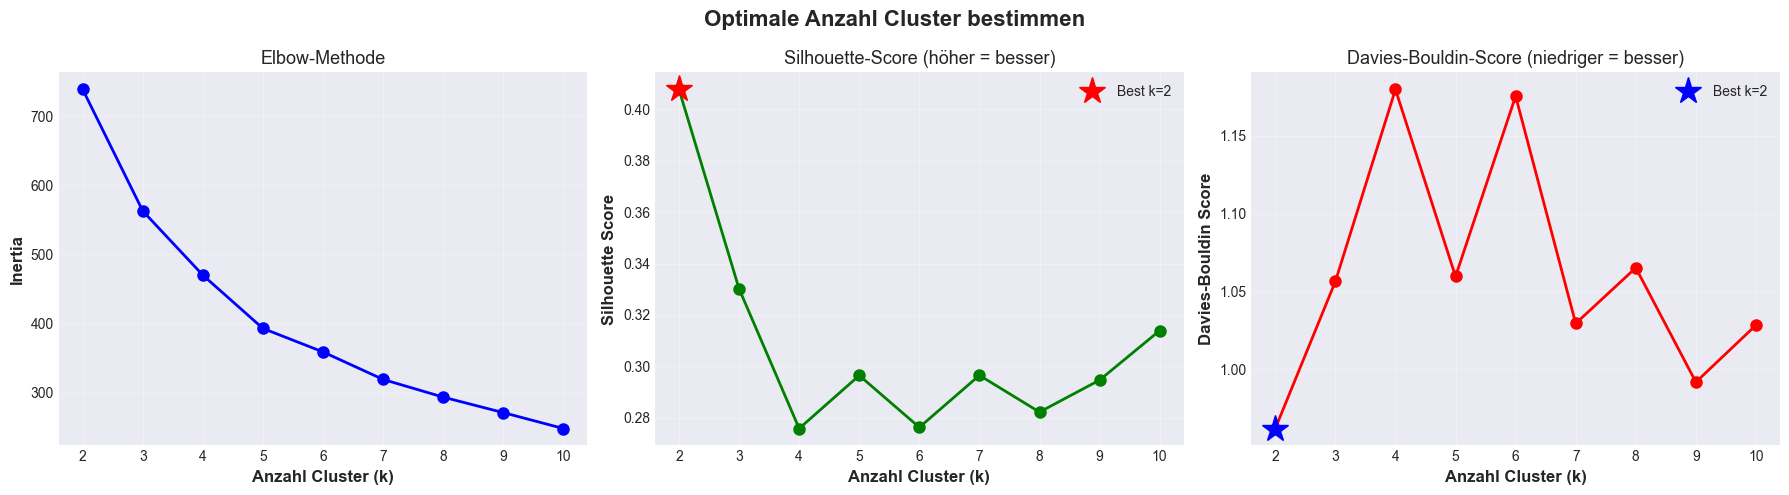


→ Empfehlung: k = 2 (basierend auf höchstem Silhouette-Score)


In [64]:
# Visualisierung der Metriken
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Optimale Anzahl Cluster bestimmen', fontsize=16, fontweight='bold')

# 1. Elbow-Methode (Inertia)
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Anzahl Cluster (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow-Methode', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# 2. Silhouette-Score
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Anzahl Cluster (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette-Score (höher = besser)', fontsize=13)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
max_idx = np.argmax(silhouette_scores)
axes[1].plot(list(k_range)[max_idx], silhouette_scores[max_idx], 'r*', markersize=20, label=f'Best k={list(k_range)[max_idx]}')
axes[1].legend()

# 3. Davies-Bouldin-Score
axes[2].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Anzahl Cluster (k)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12, fontweight='bold')
axes[2].set_title('Davies-Bouldin-Score (niedriger = besser)', fontsize=13)
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)
min_idx = np.argmin(davies_bouldin_scores)
axes[2].plot(list(k_range)[min_idx], davies_bouldin_scores[min_idx], 'b*', markersize=20, label=f'Best k={list(k_range)[min_idx]}')
axes[2].legend()

plt.tight_layout()
plt.show()

# Empfehlung
best_k_silhouette = list(k_range)[np.argmax(silhouette_scores)]
print(f"\n→ Empfehlung: k = {best_k_silhouette} (basierend auf höchstem Silhouette-Score)")

## 5. K-Means Clustering durchführen

In [65]:
# K-Means mit optimalem k
optimal_k = best_k_silhouette

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_clean['cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"K-MEANS CLUSTERING RESULTS (k = {optimal_k})")
print(f"\nCluster-Verteilung:")
print(df_clean['cluster'].value_counts().sort_index())
print(f"\nCluster-Größen (Prozent):")
print((df_clean['cluster'].value_counts(normalize=True).sort_index() * 100).round(2))

K-MEANS CLUSTERING RESULTS (k = 2)

Cluster-Verteilung:
cluster
0    218
1    121
Name: count, dtype: int64

Cluster-Größen (Prozent):
cluster
0   64.31
1   35.69
Name: proportion, dtype: float64



CLUSTER-ZENTROIDEN (Original-Skala)
           duration_min  distance_km  ascent_m  descent_m
Cluster 0        139.47         7.00    224.13     244.17
Cluster 1        256.49        12.11    474.75     534.09


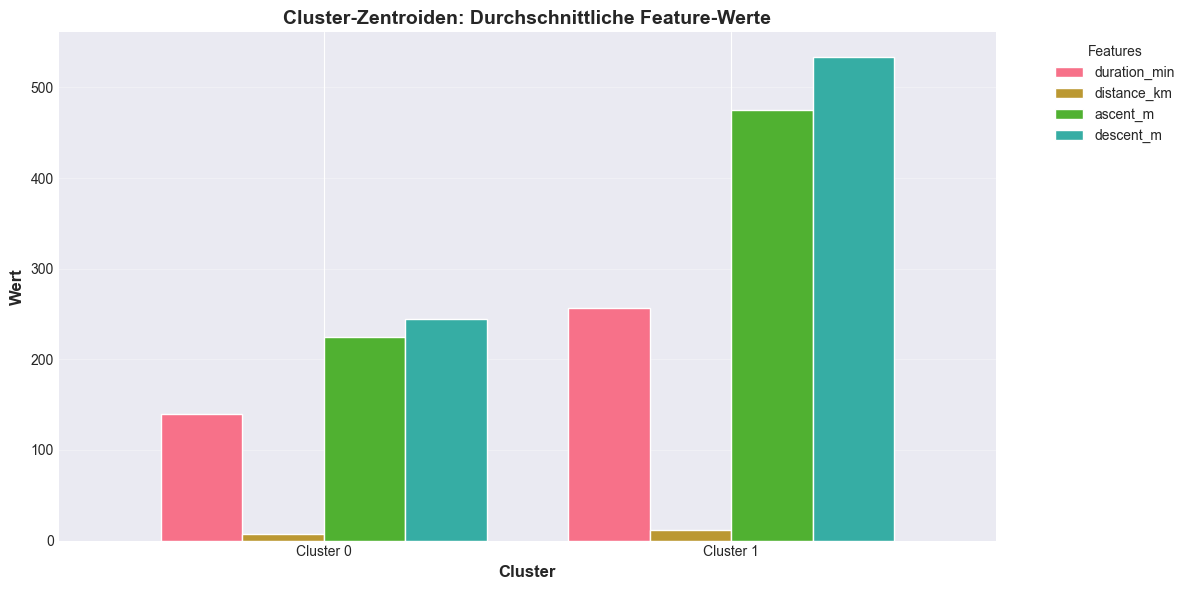

In [66]:
# Cluster-Zentroiden (zurücktransformiert auf Original-Skala)
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_original, columns=clustering_features)
centroids_df.index = [f'Cluster {i}' for i in range(optimal_k)]

print("\nCLUSTER-ZENTROIDEN (Original-Skala)")
print(centroids_df)

# Visualisierung der Zentroiden
fig, ax = plt.subplots(figsize=(12, 6))
centroids_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Cluster-Zentroiden: Durchschnittliche Feature-Werte', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Wert', fontsize=12, fontweight='bold')
ax.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Cluster-Charakterisierung

In [67]:
# Cluster-Labels basierend auf Charakteristiken
cluster_labels = {}

for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    avg_duration = cluster_data['duration_min'].mean()
    avg_distance = cluster_data['distance_km'].mean()
    avg_ascent = cluster_data['ascent_m'].mean()
    
    # Erstelle beschreibenden Label
    if avg_duration < 120 and avg_distance < 5:
        label = "Kurze Wanderungen"
    elif avg_duration < 240 and avg_distance < 10:
        label = "Mittlere Wanderungen"
    elif avg_ascent > 800:
        label = "Bergtouren (hoher Aufstieg)"
    elif avg_distance > 15:
        label = "Lange Distanzen"
    else:
        label = "Herausfordernde Touren"
    
    cluster_labels[cluster_id] = label

print("CLUSTER-LABELS")
print("="*80)
for cluster_id, label in cluster_labels.items():
    count = len(df_clean[df_clean['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {label} ({count} Wanderwege)")
    print(f"Durchschnitt: {centroids_df.loc[f'Cluster {cluster_id}'].to_dict()}")
    print()

CLUSTER-LABELS
Cluster 0: Mittlere Wanderungen (218 Wanderwege)
  Durchschnitt: {'duration_min': 139.47247706422016, 'distance_km': 6.998623853211009, 'ascent_m': 224.12844036697243, 'descent_m': 244.17431192660553}

Cluster 1: Herausfordernde Touren (121 Wanderwege)
  Durchschnitt: {'duration_min': 256.4876033057851, 'distance_km': 12.1099173553719, 'ascent_m': 474.7520661157025, 'descent_m': 534.0909090909091}



## 7. Hauptvisualisierung

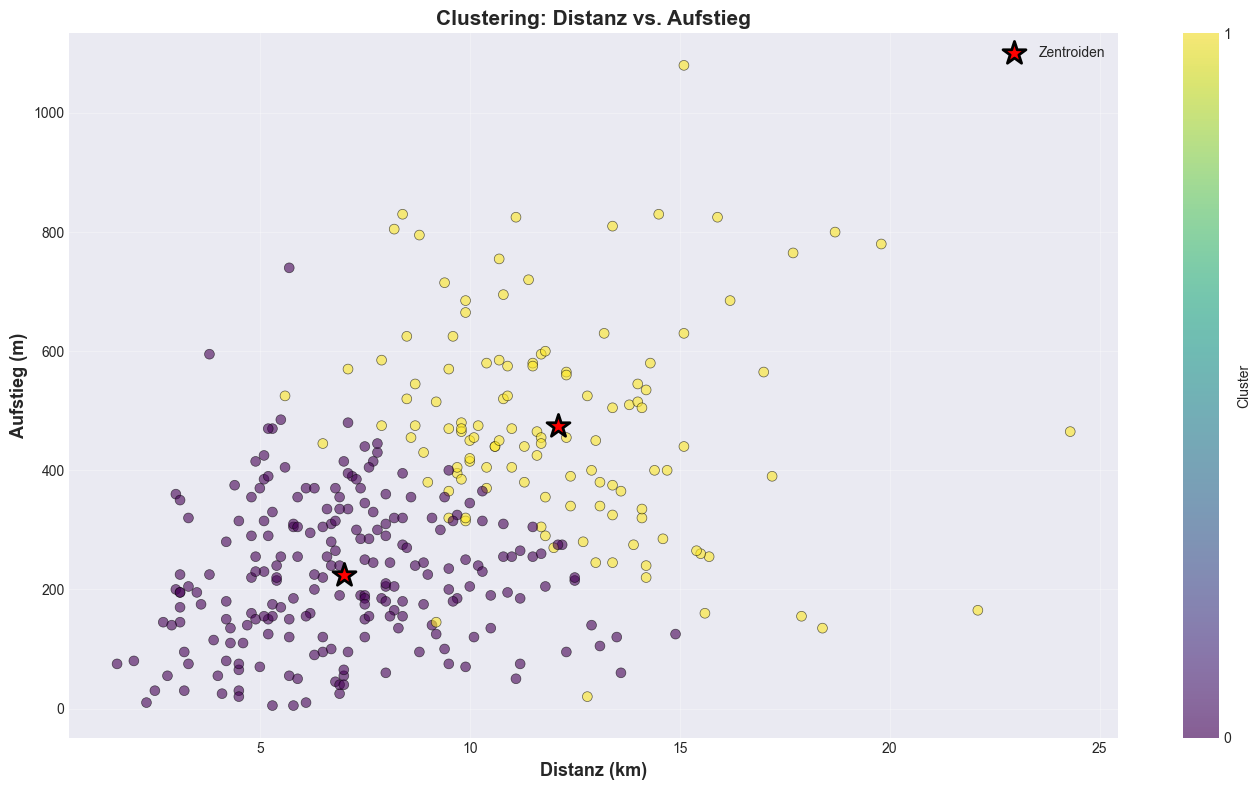

In [68]:
# Scatter-Plot: Distanz vs. Aufstieg, gefärbt nach Cluster
plt.figure(figsize=(14, 8))

scatter = plt.scatter(df_clean['distance_km'], 
                     df_clean['ascent_m'],
                     c=df_clean['cluster'],
                     cmap='viridis',
                     s=50,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

plt.xlabel('Distanz (km)', fontsize=13, fontweight='bold')
plt.ylabel('Aufstieg (m)', fontsize=13, fontweight='bold')
plt.title('Clustering: Distanz vs. Aufstieg', fontsize=15, fontweight='bold')
plt.colorbar(scatter, label='Cluster', ticks=range(optimal_k))
plt.grid(True, alpha=0.3)

# Cluster-Zentroiden hinzufügen
plt.scatter(centroids_df['distance_km'], 
           centroids_df['ascent_m'],
           c='red',
           s=300,
           marker='*',
           edgecolors='black',
           linewidth=2,
           label='Zentroiden')

plt.legend()
plt.tight_layout()
plt.show()

## 8. Cluster-Evaluation

In [69]:
# Finale Evaluation-Metriken
final_silhouette = silhouette_score(X_scaled, df_clean['cluster'])
final_davies_bouldin = davies_bouldin_score(X_scaled, df_clean['cluster'])
final_inertia = kmeans_final.inertia_

print("="*80)
print("FINALE CLUSTER-EVALUATION")
print("="*80)
print(f"\nAnzahl Cluster: {optimal_k}")
print(f"Anzahl Datenpunkte: {len(df_clean)}")
print(f"\nQualitäts-Metriken:")
print(f"- Silhouette Score: {final_silhouette:.4f} (Bereich: -1 bis 1, höher = besser)")
print(f"- Davies-Bouldin Score: {final_davies_bouldin:.4f} (niedriger = besser)")
print(f"- Inertia: {final_inertia:.2f}")

# Interpretation
print(f"\nInterpretation:")
if final_silhouette > 0.5:
    print("Silhouette Score > 0.5: Gute Cluster-Separation")
elif final_silhouette > 0.25:
    print("Silhouette Score 0.25-0.5: Akzeptable Cluster-Struktur")
else:
    print("Silhouette Score < 0.25: Schwache Cluster-Struktur")

print("="*80)

FINALE CLUSTER-EVALUATION

Anzahl Cluster: 2
Anzahl Datenpunkte: 339

Qualitäts-Metriken:
  - Silhouette Score: 0.4078 (Bereich: -1 bis 1, höher = besser)
  - Davies-Bouldin Score: 0.9620 (niedriger = besser)
  - Inertia: 738.41

Interpretation:
  ~ Silhouette Score 0.25-0.5: Akzeptable Cluster-Struktur


## 9. Daten speichern

In [70]:
# Speichere geclusterte Daten
output_file = 'schweizer_wanderwege_clustered.csv'
df_clean.to_csv(output_file, sep=';', index=False)

print(f"Geclusterte Daten gespeichert in: {output_file}")
print(f"- {len(df_clean)} Zeilen")
print(f"- {optimal_k} Cluster")
print(f"- Spalten: {df_clean.columns.tolist()}")

✓ Geclusterte Daten gespeichert in: schweizer_wanderwege_clustered.csv
  - 339 Zeilen
  - 2 Cluster
  - Spalten: ['url', 'title', 'location', 'canton', 'difficulty_level', 'difficulty_num', 'duration_min', 'distance_km', 'ascent_m', 'descent_m', 'physical_demand', 'latitude', 'longitude', 'cluster']


## 10. Zusammenfassung

Die K-Means Analyse hat die Schweizer Wanderwege in Gruppen mit ähnlichen Eigenschaften unterteilt.

**Verwendete Features:** Dauer, Distanz, Aufstieg, Abstieg

**Anwendungsfälle:**
- Empfehlungssystem für ähnliche Routen
- Routenplanung nach Schwierigkeitsgrad
- Analyse der Wanderweg-Charakteristiken

